# Predicting Pet Adoption Speeds

## Table of Contents

- [Splitting Data](#Splitting-Data)
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)  
- [Data Cleaning](#Clean-up)
- [Exploritory Data Analysis](#Exploritory-Data-Analysis)
- [Preprocessing](#Preprocessing)
- [Modeling](#Modeling)
- [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Decision Tree](#Decision-Tree)
- [Bootstrap and Bagging](#Bootstrap-and-Bagging)
- [Random Forest](#Random-Forest)
- [Extra Trees](#Extra-Trees)
- [Neural Network](#Neural-Network)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Pickling](#Pickling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data Source

https://www.kaggle.com/c/petfinder-adoption-prediction/data

## Splitting Data
To get our data in the appropriate form, please being with the "Splitting Data" notebook. We will keep them seperate to avoid any risk of mixing out holdout data with our training and test sets.

## Problem Statement

Around the world millions of dogs and cats sit in shelters, waiting for their forever-homes, which many will never find. Over the course of history, our pets become reliant on humans for food, shelter, and companionship. As a result, dogs and cats need humans to adopt them from shelters and bring them into their homes. The demand for shelter animals varies widely based on the characteristics of each animal, as well as the website post for their adoption. 

We will seek to use data from PetFinder (Malaysia) describing each pet, as well as the metadata from their Petfinder posts to predict the speed at which pets get adopted. Specifically, we will make a classifier model that will predict the speed at which the pet is adopted. We will judge our success on the accuracy of our predictions. Additionally, we will set aside a portion of our data as a validation set to confirm our model’s ability to estimate new entries.

By predicting the speed at which pets get adopted, we hope to gain insight into actionable measures we can take to increase the rate and overall number of adoptions. 

## Executive Summary

Our data contain detailed listings on approximately 15,000 cats and dogs that were listed on the PetFinder website in Malaysia, including the speed category of their adoption. From the "Data Source" listed above we used the set labled 'Train' for our analysis. The initial data was read into the "Splitting Data" notebook and divided into a training and test set as well as a holdout set, which was segmented out of the data to be revisited later for validation. 

Once we have our data read-in, we start with clean up and preliminary analysis. From the outset, we see the data is very clean, but has information we do not want to include, like "resucer_id", "state" (in Malaysia) etc. that needed to be dropped. The largest change we made was to exclude listings of more than 3 pets as these were often entire litters of puppies/kittens rather than individual pets or bonded pairs/triples.

With the cleaned and split data in hand, scaled the data (standard scalar) and began our catagorical modeling. 

After categorical modeling we did regression analysis to attempt to estimate the actual time pets are in the shelter (rather than a speed category). These results were not very stong and not instructive. Though the excercize was worthwhile, there is not much predictive ability in the regression models. 

It is important to note that many of the categories that appear numerical are actually categorical, like breed and color. Those features were indluded using one-hot-encoding for modeling. 

In [292]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import metrics as skm
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from scipy import stats

from treeinterpreter import treeinterpreter as ti

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

rdst = 815

In [293]:
pets = pd.read_csv('../../data/pets.csv')

In [294]:
pets.shape # Starting shape should be 11,244 x 24

(11244, 24)

In [295]:
pets.keys()

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

Most keys are self expalinitory, and are in the Data Dictionary in the Readme file. 

In [296]:
pets.columns = map(str.lower, pets.columns)

We have converted all of the feature labels to lowercase

# Clean-up

#### For the initial analysis, we will not look at information related to the images other than if a picture or video is present. We will remove (for now):    
  
- Description: We can use this later for NLP  
- PetID: Doesn't tell us anyting 
- State: We will explore whether or not this should be included. These are Malaysian states, so the universal applicability is unlikely.   
- The name category is likely to be important, and will be considered when we get to NLP, but will be excluded from the initial analysis.
- Rescuer ID
  
- Quantity: Unfortunately many of the listings are for entire litters of pups and kittens, given the fundamental difference in trying to adopt out entire litters compared to individual pets, we will exclude full litters. However, there are scenarios where animals need to be adopted together. These are called 'bonded pairs' and we will not exclude them.   
    
      
      
#### Other Considerations:
- Some of the categories appear numerical, but are infact categorical, and not ordinal. Those categories are:
- Breed1
- Breed2
- Color1
- Color2
- Color3
- State




In [297]:
pets.isnull().sum()

type               0
name             927
age                0
breed1             0
breed2             0
gender             0
color1             0
color2             0
color3             0
maturitysize       0
furlength          0
vaccinated         0
dewormed           0
sterilized         0
health             0
quantity           0
fee                0
state              0
rescuerid          0
videoamt           0
description        9
petid              0
photoamt           0
adoptionspeed      0
dtype: int64

In [298]:
pets.fillna(0, inplace = True)

We know that a null in the 'name' column means the pet has no name. we can replace this with zero

In [299]:
pets.isnull().sum().sum()

0

In [300]:
pets['quantity'].value_counts()

1     8612
2     1065
3      572
4      413
5      255
6      152
7       59
8       44
9       23
10      15
11       8
20       8
12       5
17       3
15       3
13       2
14       2
16       2
18       1
Name: quantity, dtype: int64

In [301]:
pets.dtypes

type               int64
name              object
age                int64
breed1             int64
breed2             int64
gender             int64
color1             int64
color2             int64
color3             int64
maturitysize       int64
furlength          int64
vaccinated         int64
dewormed           int64
sterilized         int64
health             int64
quantity           int64
fee                int64
state              int64
rescuerid         object
videoamt           int64
description       object
petid             object
photoamt         float64
adoptionspeed      int64
dtype: object

# Exploritory Data Analysis (EDA)

In [302]:
quant = pets['quantity'].value_counts()
quant


1     8612
2     1065
3      572
4      413
5      255
6      152
7       59
8       44
9       23
10      15
11       8
20       8
12       5
17       3
15       3
13       2
14       2
16       2
18       1
Name: quantity, dtype: int64

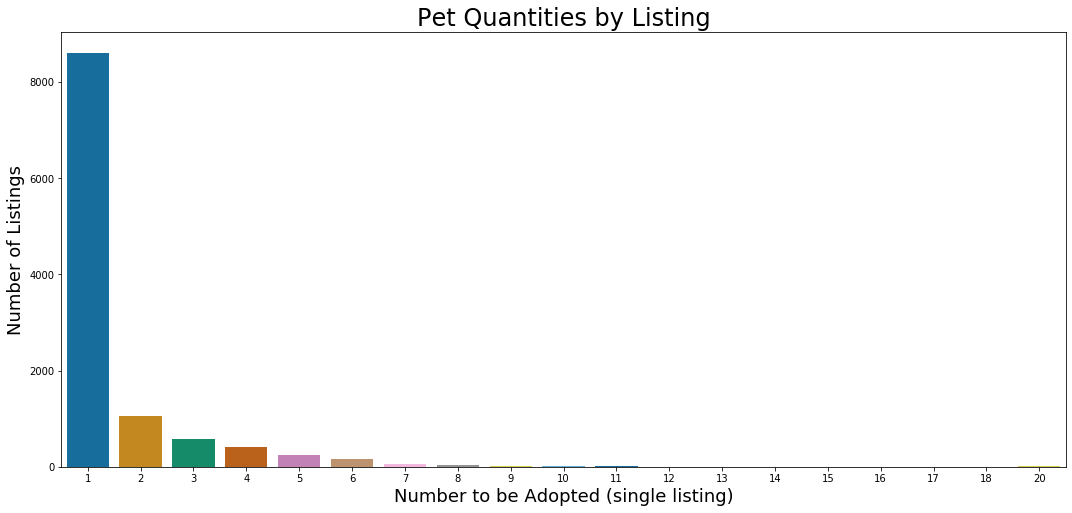

In [303]:
plt.figure(figsize = (18, 8))
sns.barplot(quant.index, quant, palette= 'colorblind' )

plt.title('Pet Quantities by Listing', size = 24)
plt.xlabel('Number to be Adopted (single listing)', size = 18)
plt.ylabel('Number of Listings', size = 18);


In [304]:
quant_m = pets[pets['quantity'] >6]
quant_m = quant_m['quantity'].value_counts()


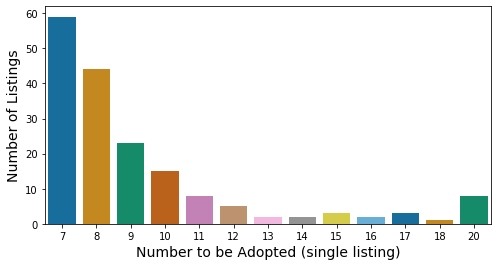

In [305]:
plt.figure(figsize = (8,4))
sns.barplot(quant_m.index, quant_m, palette = 'colorblind')
# plt.title('Listing Quantities for Groups Larger than Six', size = 14)
plt.xlabel('Number to be Adopted (single listing)', size = 14)
plt.ylabel('Number of Listings', size = 14);

There are many listings of large grouppings or litters.

Because there are fundamental differences in how we would seek to adopt out a single animal (or bonded pair/triple), we will drop all listings that contain greater than 3 animals.

In [306]:
pets.drop(pets[pets['quantity'] > 3].index, inplace = True) 

Dropped listings with more than 3 pets. We are just looking at individual adoptions, pairs, etc

In [307]:
pets.shape

(10249, 24)

In [308]:
pets.shape

(10249, 24)

In [309]:
pets.describe()

,type,age,breed1,breed2,gender,color1,color2,color3,maturitysize,furlength,vaccinated,dewormed,sterilized,health,quantity,fee,state,videoamt,photoamt,adoptionspeed
count,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000
mean,1.454191,11.098936,263.931701,72.932384,1.689043,2.276222,3.208215,1.685823,1.868670,1.475168,1.702215,1.527076,1.895112,1.038150,1.215533,22.405601,41346.459557,0.054444,3.759977,2.501512
std,0.497921,18.887640,61.323677,122.408760,0.620680,1.761076,2.791193,2.882766,0.550462,0.607166,0.674271,0.694206,0.572108,0.203905,0.529836,76.106974,32.694275,0.332007,3.315706,1.175481
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,152.000000,2.000000,3.000000,6.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1000.000000,41415.000000,8.000000,30.000000,4.000000


__Lets Explore Age__


In [310]:
pets['age'].value_counts()

2      2349
1      1383
3      1333
4       814
12      681
       ... 
135       1
238       1
102       1
86        1
255       1
Name: age, Length: 98, dtype: int64

The ages skew toward young animals, with a mean age of just under 12 months. It is unclear why this is the case, but given that it is typically harder to find homes for older pets, we expect this to be an important factor in the analysis.


In [311]:
pets['breed1'].value_counts().value_counts().sum()

161

There are 161 breeds present in our data set.

In [312]:
speed = pets.groupby(by = 'adoptionspeed').count()

In [313]:
pets['adoptionspeed'].value_counts(normalize = True)

4    0.273783
2    0.269295
3    0.218948
1    0.210947
0    0.027027
Name: adoptionspeed, dtype: float64

These are the percentages by Adoption Speed

''

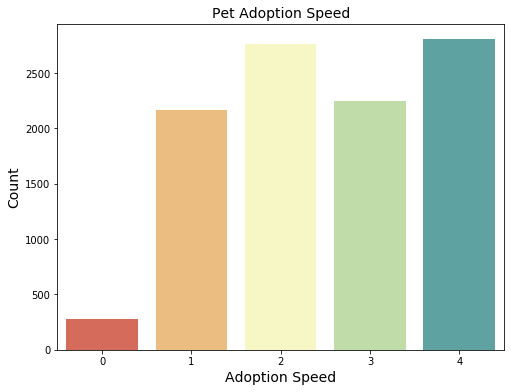

In [314]:
plt.figure(figsize = (8,6))
sns.barplot(speed.index, speed['type'] , palette = 'Spectral' )
plt.xlabel("Adoption Speed", size = 14)
plt.title("Pet Adoption Speed", size = 14)
plt.ylabel("Count", size = 14)

;

Most of the pets in the data stay in the shelter for more than 100 days or were not adopted
- 0 = Adopted the day it was listed
- 1 = Adopted in the first week
- 2 = Adopted after the first week, but in the first month
- 3 = Adopted between 31 and 90 days 
- 4 = No adoptions within 100 days (none between 90-100)

In [315]:
pets['type'].value_counts(normalize = True)

1    0.545809
2    0.454191
Name: type, dtype: float64

''

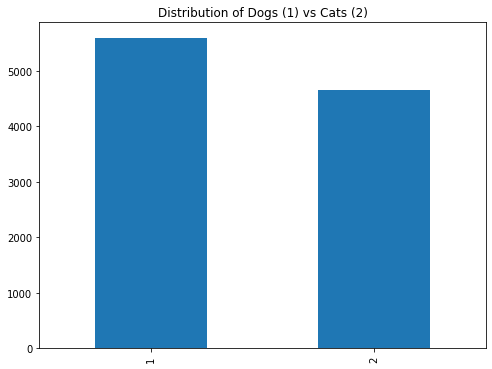

In [316]:
plt.figure(figsize = (8,6))
lbins = [1,2]
pets['type'].value_counts().plot(kind = 'bar')

plt.title("Distribution of Dogs (1) vs Cats (2)")
plt.xticks()
;

The breakdown of Dogs vs Cats is pretty close with 54.58% dogs and 45.42% cats

In [317]:
pets['breed1'].value_counts()

307    3997
266    2467
265     845
299     222
264     205
       ... 
123       1
7         1
294       1
145       1
298       1
Name: breed1, Length: 161, dtype: int64

In [318]:
speed_corr = pets.corr()[['adoptionspeed']]
speed_corr = speed_corr.sort_values(by = 'adoptionspeed', ascending = False)

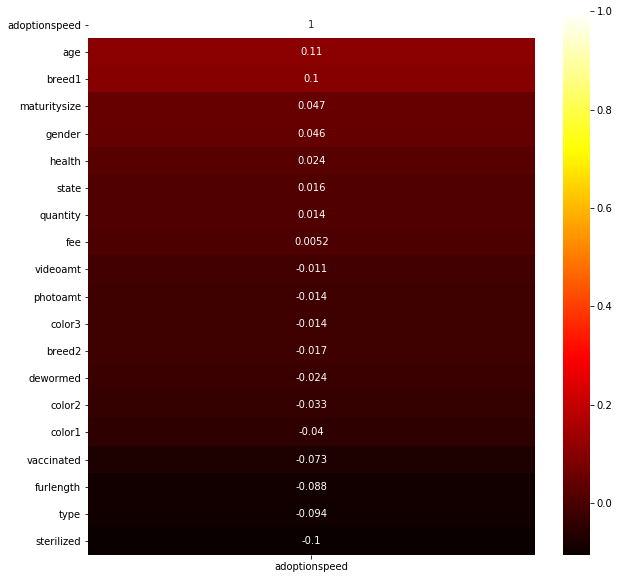

In [319]:
plt.figure(figsize = (10,10))
sns.heatmap(speed_corr, cmap = 'hot', annot= True);

Age, breed and size are unsurprisingly at the top of the list for correlation to adoption speed. Being sterilized and animal type also factor in and are negatively correlated 

In [320]:
pets['maturitysize'].value_counts() # they are numerical and ordinal based on size, so we'll keep it 'as is'

2    7036
1    2291
3     899
4      23
Name: maturitysize, dtype: int64

In [321]:
pets['fee'].describe()  # $1,000 adoption fee seems oddly high

count    10249.000000
mean        22.405601
std         76.106974
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1000.000000
Name: fee, dtype: float64

In [322]:
pets[pets['fee'] > 500]['adoptionspeed'].shape

(32,)

In [323]:
pets[(pets['fee'] > 500) & (pets['adoptionspeed']<3)].head()

,type,name,age,breed1,breed2,gender,color1,color2,color3,maturitysize,...,health,quantity,fee,state,rescuerid,videoamt,description,petid,photoamt,adoptionspeed
1280,2,0,2,285,264,2,4,0,0,2,...,1,1,750,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,Ready for let go female cute Hyper aktif n hea...,d473d632a,3.0,2
1301,2,Jacky@bulat,2,285,0,1,1,7,0,2,...,1,1,600,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,"berminat boleh call saya,kitten sngat sihat da...",08428917f,5.0,2
1572,2,Ricky,3,264,285,1,4,0,0,2,...,1,1,700,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,Ready for new home our prince Red Tabby Really...,ff867121e,2.0,2
2080,2,Luna,2,285,0,2,3,0,0,2,...,1,1,700,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,"For those are interested,pls call me female se...",09d9212f5,5.0,1
2087,1,Adpoted,24,205,0,2,1,2,7,1,...,1,1,1000,41401,67f04f1dc1f81ff09e134fb47a053b10,0,adpoted,aebf47483,2.0,0


I'm surprised that the pets with high fees (>500) tend to be adopted rather quickly. Probably higher fees charged for much sought after breeds and pets.

Of 33 pets with a fee > 500 (don't know the unit, remember this is Malaysia) 19 were adopted in the first week

In [324]:
pets['breed1'].value_counts()[:20]

307    3997
266    2467
265     845
299     222
264     205
292     183
285     158
141     145
205     141
179     126
218     118
109     108
103      73
254      72
20       70
189      65
243      64
195      58
213      54
247      53
Name: breed1, dtype: int64

In [325]:
with open('../../data/breed_labels1.json') as f:
    breeds = json.load(f)

In [326]:
len(breeds)

307

In [327]:
for n in range(1,len(breeds)):
    pets['breed1'] = pets['breed1'].replace(breeds[n]['FIELD1'], breeds[n]['FIELD2'])



pets['breed1'][:3]

0    Domestic Short Hair
1    Domestic Short Hair
2            Mixed Breed
Name: breed1, dtype: object

The above references the json file we saved as 'breeds' as a dictionary to replace the breed numbers with the name of the breed to be more readily readable.

In [328]:
pets['breed1'].value_counts()[:20]

Mixed Breed             3997
Domestic Short Hair     2467
Domestic Medium Hair     845
Tabby                    222
Domestic Long Hair       205
Siamese                  183
Persian                  158
Labrador Retriever       145
Shih Tzu                 141
Poodle                   126
Terrier                  118
Golden Retriever         108
German Shepherd Dog       73
Calico                    72
Beagle                    70
Rottweiler                65
American Shorthair        64
Schnauzer                 58
Spitz                     54
Bengal                    53
Name: breed1, dtype: int64

Mostly Mixed Breeds or general cat breads.
Most common dog is a Lab 

In [329]:
dogs = pets[pets['type'] ==1]
cats = pets[pets['type'] ==2]


In [330]:
dogs['breed1'].value_counts()[:10]

Mixed Breed            3994
Labrador Retriever      145
Shih Tzu                140
Poodle                  126
Terrier                 117
Golden Retriever        108
German Shepherd Dog      73
Beagle                   70
Rottweiler               65
Schnauzer                58
Name: breed1, dtype: int64

As expected mixed bread make up the majority with labs in second. I would have expected to find some kind of pitbull on this list, this is likely do to different preferences between the US and Malaysia.   

  
This makes me wonder if being labeled simply 'Mixed Breed' compared to having any breed at all. I'm not sure if this is possible with cats.

In [331]:
dogs['any_breed']= dogs['breed1'] != 'Mixed Breed'

C:\Users\weisj\anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [332]:
dogs.groupby('any_breed').describe() # mixed breed is false

type                                        age             ...  \
            count mean  std  min  25%  50%  75%  max   count       mean  ...   
any_breed                                                                ...   
False      3994.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  3994.0   8.030546  ...   
True       1600.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1600.0  28.258125  ...   

          photoamt       adoptionspeed                                     \
               75%   max         count      mean       std  min  25%  50%   
any_breed                                                                   
False          5.0  30.0        3994.0  2.730095  1.117339  0.0  2.0  3.0   
True           4.0  27.0        1600.0  2.283750  1.136461  0.0  1.0  2.0   

                     
           75%  max  
any_breed            
False      4.0  4.0  
True       3.0  4.0  

[2 rows x 152 columns]

In [333]:
mixed = dogs.loc[dogs['any_breed'] == True, 'adoptionspeed']
breed = dogs.loc[dogs['any_breed'] == False, 'adoptionspeed']

We've now masked by being any breed (as opposed to Mixed Breed) makes a difference

In [334]:
print('Mixed Mean Speed: ',mixed.mean())
print('Any Breed Mean Speed: ',breed.mean())

Mixed Mean Speed:  2.28375
Any Breed Mean Speed:  2.730095142714071


There is a difference here, lets find out if it is significant. We will test the following hypothisis, using an alpha value of 0.05 to deterimine signifigance: 

H0 - The true mean difference in adoption speed between dogs with a breed and without is 0

HA - The true mean difference in adoption speed between dogs with a breed and without is not 0 

In [335]:
stats.ttest_ind(breed,mixed, equal_var = False)

Ttest_indResult(statistic=13.33833467065783, pvalue=1.958942099038165e-39)

The test results show that having a breed is significant when looking at adoption speed. The p-value of 1.95 x 10^-39 is far below our alpha of 0.05

# breeds 

In [336]:
dogs.groupby('breed1')['adoptionspeed'].mean().sort_values()

breed1
Dutch Shepherd      1.0
Foxhound            1.0
Kuvasz              1.0
Lhasa Apso          1.0
Saint Bernard       1.0
                   ... 
Pointer             4.0
American Bulldog    4.0
1                   4.0
Spaniel             4.0
0                   4.0
Name: adoptionspeed, Length: 106, dtype: float64

In [337]:
dogs['breed1'].value_counts()[:10]

Mixed Breed            3994
Labrador Retriever      145
Shih Tzu                140
Poodle                  126
Terrier                 117
Golden Retriever        108
German Shepherd Dog      73
Beagle                   70
Rottweiler               65
Schnauzer                58
Name: breed1, dtype: int64

In [338]:
cats['breed1'].value_counts()[:10]

Domestic Short Hair     2467
Domestic Medium Hair     845
Tabby                    222
Domestic Long Hair       205
Siamese                  183
Persian                  158
Calico                    72
American Shorthair        64
Bengal                    53
Oriental Short Hair       48
Name: breed1, dtype: int64

Generic Domestics by far the most

### Preprocessing

In [339]:
pets = pd.get_dummies(pets, columns = ['breed1','breed2','color1', 'color2', 'color3','type', 'gender'], drop_first = True)


In [340]:
pets.to_csv('../../data/clean_pets.csv', index = False) # Clean and dummied data set

In [341]:
# Train-Test Split  - 7686x309 and 2563x309

X = pets.drop(columns = ['name', 'adoptionspeed', 'description', 'petid', 'rescuerid', 'state'])
y = pets['adoptionspeed']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = rdst)

print('X Train', X_train.shape)
print('X Test', X_test.shape)
print()
print('y Train', y_train.shape)
print('y Test', y_test.shape)

# Standard Scalar

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test  = ss.transform(X_test)
print('Z Train', Z_train.shape)
print('Z Test', Z_test.shape)


X Train (7686, 309)
X Test (2563, 309)

y Train (7686,)
y Test (2563,)
Z Train (7686, 309)
Z Test (2563, 309)


The pre-processing has left us with three sets;   
- X_train/test => Features for training and predicting
- y_train/test => Target Value (Adoption Speed)   
- Z_train/test => X scaled, fitted to the X_train set


# Modeling

### Baseline

In [342]:
pets['adoptionspeed'].value_counts(normalize = True)

4    0.273783
2    0.269295
3    0.218948
1    0.210947
0    0.027027
Name: adoptionspeed, dtype: float64

Baseline of 27.37% - This is pets that are never adopted.

###  Logistic Regression

In [357]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000, warm_start = True)
lr.fit(X_train, y_train)



C:\Users\weisj\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)

In [358]:
print("Train Score: ", lr.score(X_train, y_train))
print('Test Score: ',  lr.score(X_test, y_test))
print('Cross-Val: ',   cross_val_score(lr,Z_train, y_train).mean())

Train Score:  0.38121259432734844
Test Score:  0.35388216933281313
Cross-Val:  0.3490752170348567


In [384]:
coef = lr.coef_

In [379]:
feat = X_train.columns

In [385]:
df = pd.DataFrame(coef, columns = feat)

In [388]:
df.describe()

,age,maturitysize,furlength,vaccinated,dewormed,sterilized,health,quantity,fee,videoamt,...,color2_6,color2_7,color3_3,color3_4,color3_5,color3_6,color3_7,type_2,gender_2,gender_3
count,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
mean,1.324288e-14,1.805611e-13,-1.901812e-13,8.870127e-14,-1.350031e-13,2.267186e-13,-8.713030e-14,-9.034440e-14,1.364317e-15,-6.241674e-14,...,6.282752e-14,1.295908e-14,1.489253e-13,-2.309264e-14,2.044198e-13,3.269607e-15,6.098178e-14,5.501155e-13,2.925438e-14,-9.261480e-14
std,1.470163e-02,7.063526e-02,1.054420e-01,1.762722e-01,1.876583e-01,1.557647e-01,3.485806e-01,1.583078e-01,1.368313e-03,2.077670e-01,...,1.857880e-01,8.914492e-02,2.297707e-01,3.622970e-01,3.133047e-01,1.981509e-01,1.204963e-01,5.159612e-01,1.709898e-01,2.281580e-01
min,-1.460958e-02,-9.355296e-02,-1.177478e-01,-2.327613e-01,-1.913895e-01,-1.799455e-01,-3.200671e-01,-1.733787e-01,-1.443057e-03,-1.505504e-01,...,-2.819608e-01,-1.114348e-01,-2.051867e-01,-4.193016e-01,-3.414480e-01,-1.993636e-01,-1.454145e-01,-4.590217e-01,-2.396863e-01,-1.809946e-01
25%,-1.193841e-02,-4.820249e-02,-6.162226e-02,-1.472563e-01,-1.412865e-01,-1.240026e-01,-2.229573e-01,-1.365886e-01,-1.161094e-03,-1.469021e-01,...,-5.799245e-02,-5.904713e-02,-1.577423e-01,-1.806744e-01,-2.294305e-01,-1.280226e-01,-6.463626e-02,-3.659583e-01,-8.377595e-02,-1.447273e-01
50%,-1.008478e-03,9.577374e-03,-2.504102e-02,1.134661e-01,-6.663142e-02,-7.452661e-03,-2.127772e-01,-3.367971e-03,1.936074e-05,-3.841226e-02,...,1.735930e-02,-9.297107e-04,-1.308619e-01,-2.003120e-02,-4.732294e-02,-9.842612e-02,-1.048606e-02,-1.168254e-01,-4.979031e-04,-7.303204e-02
75%,5.781687e-03,6.086996e-02,5.077007e-02,1.296767e-01,1.923110e-01,1.362996e-01,3.392433e-01,1.218248e-01,6.933864e-04,-1.987713e-02,...,1.234229e-01,6.130130e-02,1.961287e-01,6.103176e-02,1.864460e-01,1.959689e-01,4.574722e-02,1.082108e-01,1.601329e-01,1.271790e-02
max,2.177479e-02,7.130811e-02,1.536410e-01,1.368748e-01,2.069964e-01,1.751012e-01,4.165583e-01,1.915104e-01,1.891404e-03,3.557419e-01,...,1.991710e-01,1.101103e-01,2.976622e-01,5.589753e-01,4.317555e-01,2.298433e-01,1.747896e-01,8.335946e-01,1.638272e-01,3.860360e-01


In [344]:
y_pred = lr.predict(X_test)
count_misclassified = (y_test != y_pred).sum()

print('Misclassfied: ', count_misclassified)


Misclassfied:  1656


In [375]:
print(lr.coef_)
print(X_train.columns)

[[-1.19384138e-02 -4.82024901e-02  1.53640982e-01 ...  1.08210788e-01
  -4.97903092e-04 -1.80994586e-01]
 [-1.46095822e-02 -9.35529588e-02  5.07700726e-02 ... -4.59021683e-01
  -2.39686266e-01 -1.44727275e-01]
 [-1.00847838e-03  9.57737350e-03 -2.50410219e-02 ... -1.16825354e-01
  -8.37759533e-02  1.27178974e-02]
 [ 5.78168703e-03  6.08699622e-02 -6.16222612e-02 ... -3.65958311e-01
   1.63827205e-01  3.86036008e-01]
 [ 2.17747873e-02  7.13081133e-02 -1.17747772e-01 ...  8.33594560e-01
   1.60132918e-01 -7.30320444e-02]]
Index(['age', 'maturitysize', 'furlength', 'vaccinated', 'dewormed',
       'sterilized', 'health', 'quantity', 'fee', 'videoamt',
       ...
       'color2_6', 'color2_7', 'color3_3', 'color3_4', 'color3_5', 'color3_6',
       'color3_7', 'type_2', 'gender_2', 'gender_3'],
      dtype='object', length=309)


###  K-Nearest Neighbors

In [54]:
knn = KNeighborsClassifier(n_neighbors = 5)    # Instantiate

In [55]:
# Fit model

knn.fit(Z_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [56]:
print("Train Score: ", knn.score(Z_train, y_train))
print('Test Score: ',  knn.score(Z_test, y_test))
print('Cross-Val: ',   cross_val_score(knn,Z_train, y_train).mean())

Train Score:  0.5201665365599791
Test Score:  0.3187670698400312
Cross-Val:  0.2943021423017666


### Decision Tree

In [57]:
# Does not need scaled values

dt = DecisionTreeClassifier(random_state = rdst)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=815, splitter='best')

In [58]:
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')
print('Cross-Val: ',   cross_val_score(dt,Z_train, y_train).mean())

Score on training set: 0.9798334634400209
Score on testing set: 0.32539992196644557
Cross-Val:  0.3298186137689062


At first pass it is a bit better on the test set, but massively overfit. Lets tune it

In [59]:
grid = GridSearchCV(DecisionTreeClassifier(),
                   param_grid = {'max_depth' : [2,3,4,5,6,7,8,9],
                                 'min_samples_split' : [5, 10, 15, 20, 25, 30],
                                 'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 8, 9]},
                                cv = 5,
                                 verbose = 2) # to see it work
                                

In [60]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_

[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_spl

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_s

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples

[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples

[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.0s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.0s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=15, total=   0.0s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples

[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples

[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_spl

[CV]  max_depth=5, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.0s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_spli

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_spl

[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples

[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.0s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples

[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples

[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples

[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples

[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples

[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples

[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_s

[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_spli

[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_spl

[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
              

In [61]:
dec_tree = grid.best_estimator_

In [62]:
dec_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [63]:
print('Train Score: ', dec_tree.score(X_train, y_train))
print('Test Score: ', dec_tree.score(X_test, y_test))
print('Cross Val: ', cross_val_score(dec_tree, X_train, y_train).mean())

Train Score:  0.4147801196981525
Test Score:  0.3761217323449083
Cross Val:  0.3888872907805979


In [64]:
preds = dec_tree.predict(X_test)

In [65]:
print(skm.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03        58
           1       0.32      0.31      0.32       544
           2       0.32      0.43      0.37       691
           3       0.37      0.17      0.23       569
           4       0.47      0.57      0.52       701

    accuracy                           0.38      2563
   macro avg       0.50      0.30      0.29      2563
weighted avg       0.39      0.38      0.36      2563



Looks like it pulls kind of tight to the center, which means it isn't off by a ton. Scores show we are getting better, up from 32% to 37%

### Bootstrap and Bagging

In [66]:
# We will use the decision tree above as our starting point

# Bootstrap samples
def bootstrap(data, straps):
    output = []
    
    for strap in range (straps):
            bs = data.sample(n=data.shape[0], replace = True)
            output.append(bs)
    return output
      
# Adapted from Boom D. - NYC    

In [67]:
# Lets Generate Samples
np.random.seed(rdst)

predictions = pd.DataFrame(index = X_test.index)

# decision trees
for B in range (1,21):
    X_sample = X_train.sample(n = (X_train.shape[0]), replace = True)
    y_sample = y_train[X_sample.index]
    
    tree = DecisionTreeClassifier(random_state=rdst)  # Instantiate trees
    tree.fit(X_sample, y_sample)           # Fit
    predictions[f'tree{B}'] = tree.predict(X_test)
predictions.head()
    
                       
                       

,tree1,tree2,tree3,tree4,tree5,tree6,tree7,tree8,tree9,tree10,tree11,tree12,tree13,tree14,tree15,tree16,tree17,tree18,tree19,tree20
5389,2,1,2,3,1,3,4,3,2,1,1,2,2,2,3,4,1,1,2,2
3082,2,3,3,3,3,3,3,3,3,3,2,3,2,3,2,2,3,3,2,2
7731,2,2,1,3,2,2,2,3,2,2,4,2,2,2,4,2,2,2,2,2
8102,1,2,3,3,2,4,2,2,4,2,3,2,1,2,2,0,4,4,1,2
6947,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,3,2,2,2


In [68]:
bag = BaggingClassifier(dec_tree, n_estimators=300,  random_state= rdst)  # Instantiate
bag.fit(X_train, y_train)                                                # Fit 

print('Train: ', bag.score(X_train, y_train))
print('Test: ', bag.score(X_test, y_test))
print('Cross Val: ', cross_val_score(bag,X,y).mean())



Train:  0.4336455893832943
Test:  0.37807257120561844
Cross Val:  0.39457472413669964


Not much better than the decision tree.

### Random Forest

In [69]:
rf = RandomForestClassifier()
params = {
    'n_estimators' : [200,300, 400, 500],
    'max_features' : [None, 4, 5, 6, 7, 8],
    'max_depth' : [None, 6 ,10 ,15]
}

gs = GridSearchCV(rf, param_grid = params, cv = 5)
gs.fit(X_train, y_train)
print('Best Score: ', gs.best_score_)


Best Score:  0.404107185311091


In [70]:
gs.best_params_

{'max_depth': 15, 'max_features': None, 'n_estimators': 400}

In [71]:
print('RF Test Score: ', gs.score(X_test, y_test))
    

RF Test Score:  0.39172844323058914


In [72]:
preds = gs.predict(X_test)

Out of 2,563 test observations, we were exactly right 1,013 times. This is an accuracy of 39.5%  
  
While this number doesn't seem that great, it is also valuble to be 'close'. For example, there are 186 pets that were predicted to be adopted within a month that were actually adopted in the first week. While this isn't an 'accurate' prediction, it is still instructive.


### Extra Trees

In [74]:
extree = ExtraTreesClassifier()
cross_val_score(extree, X_train, y_train, cv = 5).mean()

0.3494638111667722

In [75]:
extree = ExtraTreesClassifier()
params = {
    'n_estimators' : [10, 50, 100, 200,300],
    'max_features' : [None, 4, 5, 6, 7, 8],
    'max_depth' : [None, 6 ,10 ,15, 20]
}

gsext = GridSearchCV(extree, param_grid = params, cv = 5)
gsext.fit(X_train, y_train)
print('Best Score: ', gsext.best_score_)
gsext.best_params_

Best Score:  0.3858937707336924


{'max_depth': 10, 'max_features': None, 'n_estimators': 50}

In [76]:
print('Train: ', gsext.score(X_train, y_train))
print('Test: ', gsext.score(X_test, y_test))
print('Cross Val: ', cross_val_score(gsext,X,y).mean())

Train:  0.5539942753057507
Test:  0.37690206788919234
Cross Val:  0.38559806687378734


The Extra trees isn't as good as the Random Forest, Well stick with that for now.  


### Neural Network

In [77]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [78]:
Z_train.shape



(7686, 309)

In [79]:
model = Sequential()                        # Inatantiate
model.add(Dense(128,                        # Input Layer
               input_shape = (309,), 
               activation = 'relu'))
model.add(Dense(64, activation = 'relu'))   # First Hidden Layer
model.add(Dropout(.5))                      # First Dropout
model.add(Dense(32, activation = 'relu'))   # Second Hidden Layer
model.add(Dropout(.5))
model.add(Dense(5, activation = 'softmax')) # Output Layer

In [80]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [81]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0, patience=5, verbose =1, mode='auto')
history_es = model.fit(Z_train, y_train, validation_data = (Z_test, y_test),epochs = 5000, batch_size = 512, callbacks=[early_stop])

Train on 7686 samples, validate on 2563 samples
Epoch 1/5000
7686/7686 [==============================] - 0s 25us/step - loss: 1.8263 - accuracy: 0.2006 - val_loss: 1.5834 - val_accuracy: 0.2591
Epoch 2/5000
7686/7686 [==============================] - 0s 22us/step - loss: 1.6529 - accuracy: 0.2368 - val_loss: 1.5691 - val_accuracy: 0.2688
Epoch 3/5000
7686/7686 [==============================] - 0s 17us/step - loss: 1.6147 - accuracy: 0.2460 - val_loss: 1.5556 - val_accuracy: 0.2708
Epoch 4/5000
7686/7686 [==============================] - 0s 18us/step - loss: 1.5817 - accuracy: 0.2649 - val_loss: 1.5432 - val_accuracy: 0.2653
Epoch 5/5000
7686/7686 [==============================] - 0s 21us/step - loss: 1.5558 - accuracy: 0.2663 - val_loss: 1.5262 - val_accuracy: 0.2844
Epoch 6/5000
7686/7686 [==============================] - 0s 20us/step - loss: 1.5435 - accuracy: 0.2693 - val_loss: 1.5126 - val_accuracy: 0.2957
Epoch 7/5000
7686/7686 [==============================] - 0s 19us/step

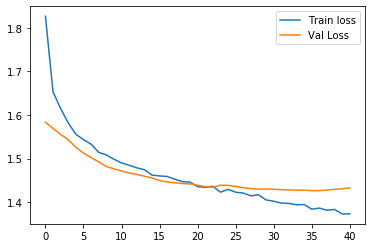

In [82]:
plt.plot(history_es.history['loss'], label='Train loss')
plt.plot(history_es.history['val_loss'], label='Val Loss')
plt.legend();

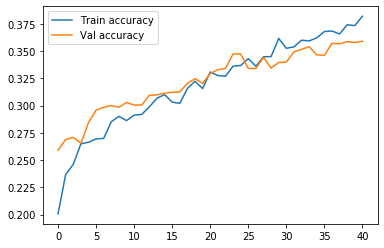

In [83]:
plt.plot(history_es.history['accuracy'], label='Train accuracy')
plt.plot(history_es.history['val_accuracy'], label='Val accuracy')
plt.legend();

### GridSearch

In [84]:
# def grid_search(layer_one_neurons = 64, layer_two_neurons = 32):
#     model_gs = Sequential()                        # Instantiate
#     model.add(Dense(128,                           # Input Layer
#                    input_shape = (309,), 
#                    activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))      # First Hidden Layer
#     model.add(Dropout(.5))                         # First Dropout
#     model.add(Dense(32, activation = 'relu'))      # Second Hidden Layer
#     model.add(Dropout(.5))                         # Second Dropout
#     model.add(Dense(5, activation = 'softmax'))    # Output Layer
#     return model

# nn = KerasClassifier(build_fn = grid_search, batch_size = 512, verbose = 1)

# params = {
#     'epochs' : [1_000],
#     'layer_one_neurons' : [32],
#     'layer_one_neurons' : [16]
# }

# gs = GridSearchCV(nn, param_grid = params, cv = 5)
# gs.fit(Z_train, y_train)
# print(gs.best_score_)
# gs.best_params_

## Model Selection

The NN needed one hot encoded targets for multiclass classification. We need to convert our y label back to a single value to get scores. We will reset the y_value definition

In [90]:
# Train-Test Split  - 7686x309 and 2563x309

X = pets.drop(columns = ['name', 'adoptionspeed', 'description', 'petid', 'rescuerid', 'state'])
y = pets['adoptionspeed']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = rdst)

print('X Train', X_train.shape)
print('X Test', X_test.shape)
print()
print('y Train', y_train.shape)
print('y Test', y_test.shape)

# Standard Scalar

ss = StandardScaler()


Z_train = ss.fit_transform(X_train)
Z_test  = ss.transform(X_test)
Z = ss.transform(X)
print('Z Train', Z_train.shape)
print('Z Test', Z_test.shape)


X Train (7686, 309)
X Test (2563, 309)

y Train (7686,)
y Test (2563,)
Z Train (7686, 309)
Z Test (2563, 309)


In [91]:
print('Train: ', knn.score(Z_train, y_train))
print('Test: ', knn.score(Z_test, y_test))
print('Cross Val: ', cross_val_score(knn,Z,y).mean())

Train:  0.5201665365599791
Test:  0.3187670698400312
Cross Val:  0.30461555309550165


In [92]:
print('Train: ', grid.score(X_train, y_train))
print('Test: ', grid.score(X_test, y_test))
print('Cross Val: ', cross_val_score(grid,X,y).mean())

Train:  0.4147801196981525
Test:  0.3761217323449083
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_s

[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_spl

[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_spli

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_spli

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_spli

[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_spli

[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_spli

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_spl

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=6, min_samples_sp

[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=8, min_samples

[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples

[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples

[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples

[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples

[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples

[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples

[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_s

[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_spli

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_spl

[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_

[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples

[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples

[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples

[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples

[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=1

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=25, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples

[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples

[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples

[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.0s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples

[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples

[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples

[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_spl

[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_spli

[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_s

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples

[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples

[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples

[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples

[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples

[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples

[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_spl

[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_spli

[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_s

[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples

[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples

[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_spl

[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=25, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_

[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples

[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples

[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=9, min_samples

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=5, min_samples

[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples

[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples

[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_spl

[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_spli

[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_s

[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples

[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples

[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples

[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples

[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples

[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_

[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_spl

[CV]  max_depth=8, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_spli

[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_spl

[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_

[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples

[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.2s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples

[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ......

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=25, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples

[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples

[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=20, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples

[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples

[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples

[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples

[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_s

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_spl

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_spli

[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_s

[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=6, min_samples

[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=6, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=6, min_samples_leaf=8, min_samples

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples

[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples

[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples

[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples

[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples

[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_

[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_spl

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_spli

[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_spl

[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_

[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples

[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples

[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_sp

[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6, min_samples_spli

[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_s

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_s

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_s

[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_s

[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples

[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples

[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples

[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples

[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_

[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_sp

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_spli

[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_sp

[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_

[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples

[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples

[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples

[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples

[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_sp

[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_spli

[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=9, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=9, min_samples_leaf=9, min_samples_split=30, total=   0.1s
Cross Val:  0.38667128521944083


[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  2.2min finished


In [93]:
print('Train: ', bag.score(X_train, y_train))
print('Test: ', bag.score(X_test, y_test))
print('Cross Val: ', cross_val_score(bag,X,y).mean())

Train:  0.4336455893832943
Test:  0.37807257120561844
Cross Val:  0.39457472413669964


In [94]:
print('Train: ', gs.score(X_train, y_train))
print('Test: ', gs.score(X_test, y_test))
print('Cross Val: ', cross_val_score(gs,X,y).mean())

Train:  0.8242258652094717
Test:  0.39172844323058914
Cross Val:  0.39564860907759886


In [95]:
print('Train: ', gsext.score(X_train, y_train))
print('Test: ', gsext.score(X_test, y_test))
print('Cross Val: ', cross_val_score(gsext,X,y).mean())

Train:  0.5539942753057507
Test:  0.37690206788919234
Cross Val:  0.38764708543132287


As we can see, the Random Forest model has the highest accuracy (though it is also the most overfit). Because of the time involved getting the cross-val scores, we've included a summary chart below. 

<img src="summary.jpg" style="float: center; margin: 20px; height: 500">


## Model Evaluation

In [97]:
gs.best_params_

{'max_depth': 15, 'max_features': None, 'n_estimators': 400}

In [98]:
print('RF Test Score: ', gs.score(X_test, y_test))
    

RF Test Score:  0.39172844323058914


In [99]:
rf = gs.best_estimator_

In [100]:
preds = rf.predict(X_test)

''

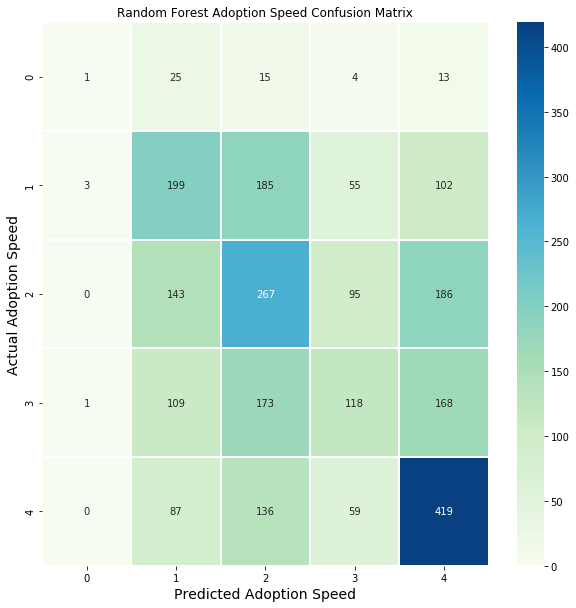

In [101]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap = 'GnBu', fmt='g', annot = True, linewidth = 1 )
plt.title("Random Forest Adoption Speed Confusion Matrix")
plt.xlabel("Predicted Adoption Speed", size = 14)
plt.ylabel("Actual Adoption Speed", size = 14)
;

In [102]:
classification_report(y_test, preds, output_dict = True)

{'0': {'precision': 0.2,
  'recall': 0.017241379310344827,
  'f1-score': 0.031746031746031744,
  'support': 58},
 '1': {'precision': 0.35346358792184723,
  'recall': 0.36580882352941174,
  'f1-score': 0.35953026196928634,
  'support': 544},
 '2': {'precision': 0.3440721649484536,
  'recall': 0.38639652677279307,
  'f1-score': 0.3640081799591003,
  'support': 691},
 '3': {'precision': 0.3564954682779456,
  'recall': 0.20738137082601055,
  'f1-score': 0.2622222222222222,
  'support': 569},
 '4': {'precision': 0.47184684684684686,
  'recall': 0.5977175463623395,
  'f1-score': 0.5273757079924482,
  'support': 701},
 'accuracy': 0.39172844323058914,
 'macro avg': {'precision': 0.34517561359901866,
  'recall': 0.3149091293601799,
  'f1-score': 0.30897648077781775,
  'support': 2563},
 'weighted avg': {'precision': 0.38051058092027196,
  'recall': 0.39172844323058914,
  'f1-score': 0.377623956477351,
  'support': 2563}}

In [103]:
feat_importance = list(zip(X_train.columns, rf.feature_importances_))
importance = feat_importance.sort(reverse = True)

In [104]:
imp_all = pd.DataFrame(feat_importance)
imp_all = imp_all.sort_values(by = [1], ascending = True)
imp = imp_all.tail(15)
imp



,0,1
23,color2_2,0.020653
13,color3_7,0.020750
18,color2_7,0.024675
29,color1_2,0.024680
4,quantity,0.026929
214,breed1_Mixed Breed,0.027674
9,gender_2,0.032573
12,dewormed,0.034912
1,vaccinated,0.035744
10,furlength,0.037408


''

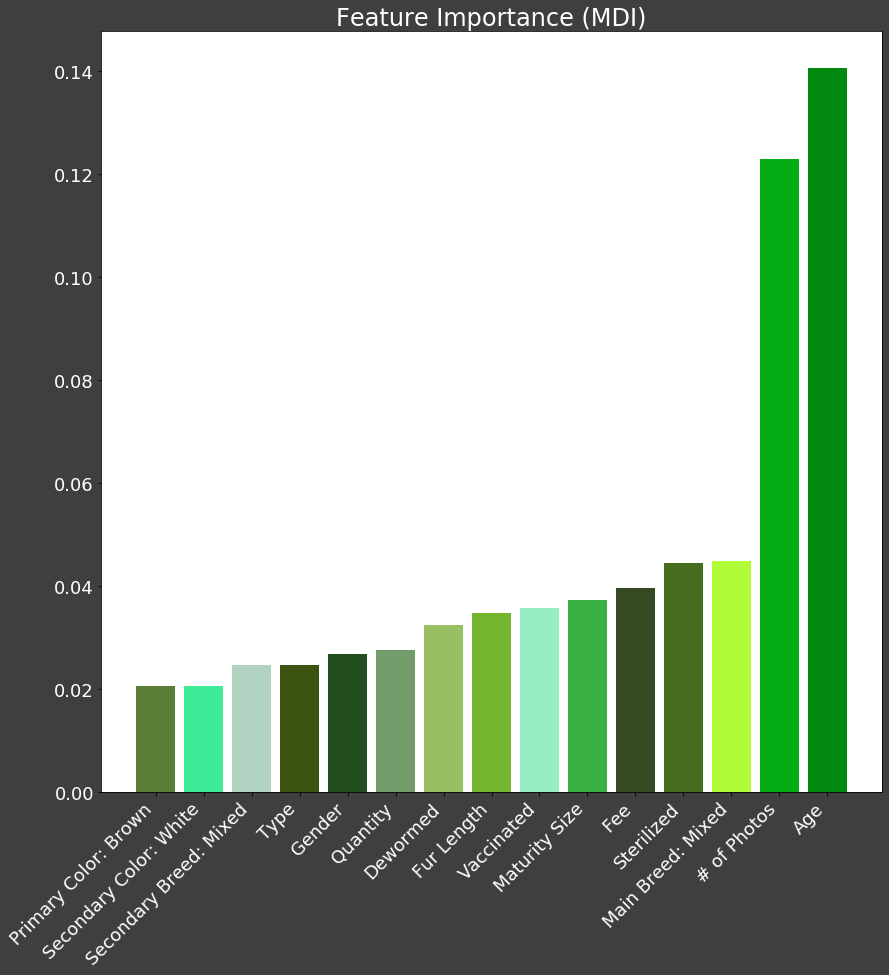

In [108]:
plt.figure(figsize = (14,14), facecolor = ('#3f3f3f'))

plt.bar(imp[0],imp[1], 
         color = ['#597d35','#3cec97','#b2d3c2', '#3a5311', '#234f1e', '#729c69', '#98bf64','#74b62e', '#98edc3','#3bb143','#354a21','#466d1e', '#b0fc38', '#03ac13', '#028910'],
         tick_label = ['Primary Color: Brown', 'Secondary Color: White', 'Secondary Breed: Mixed', 'Type','Gender', 'Quantity', 'Dewormed', 'Fur Length', 'Vaccinated', 'Maturity Size', 'Fee', 'Sterilized', 'Main Breed: Mixed', '# of Photos', 'Age'])
   
plt.xticks(rotation=45, ha='right', color = 'white', size = 18 ) 
plt.yticks(color='white', size = 18)
plt.title("Feature Importance (MDI)", size = 24, color = 'white')

;

This is the feature importantce. It show's what features have the most impact on predicting the target variable. Because this is based on the training data, it is vulnerable to overfitting and giving additional 'credit' to those overfit features. MDI is the Mean Decrease in Impurity.

In [109]:
res = permutation_importance(rf, X_test, y_test, n_repeats = 10, 
                                random_state = rdst)

In [110]:
results = list(zip(X_test.columns, res))
result = results.sort(reverse = True)

For additonal interperatability we will also pull out the coefficents for the logistic regression model. 

In [ ]:
y_preds

# Conclusions and Recommendations

Most of our models performed well in the range of 35%+ accuracy. We ultimately selected the Random Forest model as it produced the best results, which were about 11.5 percentage points above the baseline accuracy.  

We are able to conclude from our work that there are key factors that affect the speed at which dogs and cats are adopted. Those factors include age, spay/neuter status, breed and the number of photos available. Being able to more accurately predict the speed at which pets are adopted will allow us to better allocate resources to get the most pets into forever homes. 

Other Recommendations:
Include multiple pictures of the pet

Even if the breed is unknown or mixed, it is best to take a guess and include a breed rather than ‘mixed’

Spay/Neutering the pet helps in adoption, and helps keep the population down for the future

Focusing on pets identified as being more difficult to home may increase their likelihood of finding a forever home. 

## Pickling

In [ ]:
# pip install treeinterpreter


In [ ]:
best_rf = 'finalized_rf.sav'
pickle.dump(rf, open(best_rf, 'wb'))

We also need the scaler, so we will pickle that below

In [ ]:
sscaler = 'finalized_ss.sav'
pickle.dump(ss, open(sscaler, 'wb'))

## References

References:  
https://www.linkedin.com/pulse/kaggle-competition-multi-class-classification-image-alexandra/  
https://www.kaggle.com/c/petfinder-adoption-prediction/data    
https://stackoverflow.com/questions/53886370/multi-class-multi-label-confusion-matrix-with-sklearn
https://towardsdatascience.com/interpreting-random-forest-and-other-black-box-models-like-xgboost-80f9cc4a3c38  
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/  
https://stackoverflow.com/questions/44266677/machine-learning-test-set-with-fewer-features-than-the-train-set